# Mapping UK data sets

Import dependencies and create the Spark context

In [1]:
from __future__ import print_function

from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, struct, count, col, isnan, when, year, month
from pyspark.sql.types import BooleanType, IntegerType, FloatType, DateType, StringType

import os
import sys
from datetime import datetime
if sys.version_info.major == 2:
    from pathlib2 import Path
else:
    from pathlib import Path
from pprint import pprint

import numpy as np
import pandas as pd
import pyproj
import shapefile as shp
from matplotlib import pyplot as plt
from matplotlib import colorbar, colors
from matplotlib.collections import PatchCollection
from matplotlib.patches import Polygon, Rectangle
from matplotlib.text import Annotation
from tabulate import tabulate

plt.rcParams['figure.dpi'] = 100

spark = SparkSession.builder.appName("uk_data_mapping").config(conf=SparkConf()).getOrCreate()

Current Spark configuration

In [2]:
sc = SparkContext.getOrCreate()
sc._conf.getAll()

[('spark.driver.port', '40153'),
 ('spark.driver.host', '192.168.1.8'),
 ('spark.default.parallelism', '64'),
 ('spark.executor.id', 'driver'),
 ('spark.task.maxFailures', '1'),
 ('spark.driver.memory', '1g'),
 ('spark.app.name', 'PySparkShell'),
 ('spark.app.id', 'local-1540577348716'),
 ('spark.pyspark.python', '/usr/bin/python3.6'),
 ('spark.sql.catalogImplementation', 'hive'),
 ('spark.local.dir', '/media/csk13/d/scratch'),
 ('spark.rdd.compress', 'True'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.master', 'local[*]'),
 ('spark.submit.deployMode', 'client'),
 ('spark.ui.showConsoleProgress', 'true')]

---

## Ordinance Survey Boundary-Line data set
The boundary line data set contains `.shp` _shapefiles_ which store the shapes of various UK administrative regions along with data associated with each region. The data set is freely available and can be [downloaded](https://www.ordnancesurvey.co.uk/business-and-government/products/boundary-line.html) from the ordinance survey website.

In [56]:
!tree ${DATA_BDLINE}/Data/GB

/home/csk13/src/uk-data-mapping/bdline/Data/GB
├── county_electoral_division_region.dbf
├── county_electoral_division_region.prj
├── county_electoral_division_region.shp
├── county_electoral_division_region.shx
├── county_region.dbf
├── county_region.prj
├── county_region.shp
├── county_region.shx
├── district_borough_unitary_region.dbf
├── district_borough_unitary_region.prj
├── district_borough_unitary_region.shp
├── district_borough_unitary_region.shx
├── district_borough_unitary_ward_region.dbf
├── district_borough_unitary_ward_region.prj
├── district_borough_unitary_ward_region.shp
├── district_borough_unitary_ward_region.shx
├── european_region_region.dbf
├── european_region_region.prj
├── european_region_region.shp
├── european_region_region.shx
├── greater_london_const_region.dbf
├── greater_london_const_region.prj
├── greater_london_const_region.shp
├── greater_london_const_region.shx
├── high_water_polyline.dbf
├── high_water_polyline.prj
├── high_water_polyline.shp
├── high_

Let's take a look at the `district_borough_unitary_region` data set

In [6]:
BDLINE_DIR = os.getenv('DATA_BDLINE')
BDLINE_DISTRICT_CSV = os.path.join(BDLINE_DIR, 'Data/GB/district_borough_unitary_region.shp')
BDLINE_COUNTY_CSV = os.path.join(BDLINE_DIR, 'Data/Supplementary_Ceremonial/Boundary-line-ceremonial-counties_region.shp')
BDLINE_LONDON_CSV = os.path.join(BDLINE_DIR, 'Data/GB/greater_london_const_region.shp')

In [7]:
sf_district = shp.Reader(BDLINE_DISTRICT_CSV)

Available fields in the shapefile data

In [8]:
sf_district.fields

[('DeletionFlag', 'C', 1, 0),
 ['NAME', 'C', 60, 0],
 ['AREA_CODE', 'C', 3, 0],
 ['DESCRIPTIO', 'C', 50, 0],
 ['FILE_NAME', 'C', 50, 0],
 ['NUMBER', 'N', 11, 0],
 ['NUMBER0', 'N', 11, 0],
 ['POLYGON_ID', 'N', 11, 0],
 ['UNIT_ID', 'N', 11, 0],
 ['CODE', 'C', 9, 0],
 ['HECTARES', 'N', 12, 3],
 ['AREA', 'N', 12, 3],
 ['TYPE_CODE', 'C', 2, 0],
 ['DESCRIPT0', 'C', 25, 0],
 ['TYPE_COD0', 'C', 3, 0],
 ['DESCRIPT1', 'C', 36, 0]]

Let's take a look at the first record

In [9]:
sf_district.record(0)  # or sf_district.records()[0]

['Wycombe District',
 'DIS',
 'District',
 'BUCKINGHAMSHIRE_COUNTY',
 5,
 377,
 51844,
 11882,
 'E07000007',
 32457.21,
 0.0,
 'AA',
 'CIVIL ADMINISTRATION AREA',
 '',
 '']

The geometry for each of the districts is defined within the `.shp` file and can be accessed through the `shape` and `shapes` methods. According to the [Boundary-Line User Manual](https://digimap.edina.ac.uk/webhelp/os/data_files/os_manuals/boundary-line-user-guide_1_18.pdf) (p.91), all Ordnance Survey geometry is defined in the OSGB36 projection.

>**National Grid**  
A unique referencing system that can be applied to all Ordnance Survey maps of Great Britain (GB) at all
scales. It is used by Ordnance Survey on all post-war mapping to provide an unambiguous spatial reference
in Great Britain for any place or entity whatever the map scale. The National Grid is defined by the OSGB36®
spheroid.

In [10]:
sf_district.shape(0).points[:5]

[(476152.20059080864, 183567.80351806417),
 (476146.50325358775, 183569.70297435045),
 (476164.7990441711, 183643.40187825868),
 (476191.10078908363, 183743.60319592984),
 (476205.4966657661, 183806.2952505159)]

Some shapes contain multiple components so care must be taken to draw each as a separate closed polygon. For multi-part shapes, the list `parts` will contain multiple offsets which indicate the location of the first point in the corresponding `points` array.

In [11]:
sf_district.shape(5).parts

[0, 6570]

It is necesary to map district codes to the associated shp record

In [12]:
district_to_shp_record_map = {
    x[8]: i for i, x in enumerate(sf_district.records())
}

---

## UK HM Land Registry Price Paid data set

Data on the price paid for houses in the UK from 1995 to present can be [downloaded](https://www.gov.uk/government/statistical-data-sets/price-paid-data-downloads) for free from HM Land Registry. Details about the data including a description of the fields are available [here](https://www.gov.uk/guidance/about-the-price-paid-data).

It is stated that data from the most recent 2 months is **not reliable** due to the typical time of between 2 weeks and 2 months between the sale of a property and registration.

>The amount of time between the sale of a property and the registration of this information with HM Land Registry varies. It typically ranges between 2 weeks and 2 months. Data for the two most recent months is therefore incomplete and does not give an indication of final monthly volumes. 

In [13]:
PP_CSV = os.getenv('DATA_PP_COMPLETE')

Let's take a look at the first few entries in the data set

In [15]:
!head -3 $PP_CSV

"{BC7C2FC5-6B3D-41DF-981E-D02E70CBE6C3}","62750","1995-10-31 00:00","BS6 7TF","T","Y","F","59","","THE FURLONG","BRISTOL","BRISTOL","BRISTOL","AVON","A","A"
"{BF52C772-ED3F-485E-83CF-CCA3C3F5F3B5}","175000","1995-10-27 00:00","NE20 9PH","D","Y","F","14","","OAKLANDS","PONTELAND","NEWCASTLE UPON TYNE","CASTLE MORPETH","NORTHUMBERLAND","A","A"
"{752C4832-3E46-4BC1-9360-D3B5DFE358D8}","15000","1995-04-21 00:00","WV2 4NY","T","N","F","40","","ARGYLE ROAD","WOLVERHAMPTON","WOLVERHAMPTON","WOLVERHAMPTON","WEST MIDLANDS","A","A"


### Loading the data into python
The dataset is approximately 4GB in size, and although this is not very big, it's big enough to be problematic to work with. Attempting to load all of the data into a Pandas DataFrame exhausts all system memory. Instead the data can be loaded into a Spark data frame.

In [16]:
%%time
pp = spark.read.csv(PP_CSV, header=False, inferSchema=True)

CPU times: user 5.46 ms, sys: 227 µs, total: 5.69 ms
Wall time: 19.9 s


Number of rows in the dataset

In [17]:
%%time
# 64 partitions
pp.count()

CPU times: user 1.4 ms, sys: 1.47 ms, total: 2.87 ms
Wall time: 12.4 s


22859090

The dataset does not contain column names so these must be added manually based on the information found through the link above.

In [18]:
col_names = {
    0: 'id',
    1: 'price',
    2: 'date_of_transfer',
    3: 'postcode',
    4: 'property_type',
    5: 'is_new',
    6: 'duration',
    7: 'PAON',
    8: 'SAON',
    9: 'street',
    10: 'locality',
    11: 'town_city',
    12: 'district',
    13: 'county',
    14: 'ppd_category_type',
    15: 'record_status',
}

col_name_list = [
    v for k, v in sorted(
        [(k, v) for k, v in col_names.items()], key=lambda x: x[0]
    )
]

Rename all the columns in the dataframe

In [19]:
%%time
# 64 partitions
pp = pp.toDF(*col_name_list)

CPU times: user 1.39 ms, sys: 615 µs, total: 2.01 ms
Wall time: 12.1 ms


Display the schema for the dataframe - field names, types

In [20]:
pp.printSchema()

root
 |-- id: string (nullable = true)
 |-- price: integer (nullable = true)
 |-- date_of_transfer: string (nullable = true)
 |-- postcode: string (nullable = true)
 |-- property_type: string (nullable = true)
 |-- is_new: string (nullable = true)
 |-- duration: string (nullable = true)
 |-- PAON: string (nullable = true)
 |-- SAON: string (nullable = true)
 |-- street: string (nullable = true)
 |-- locality: string (nullable = true)
 |-- town_city: string (nullable = true)
 |-- district: string (nullable = true)
 |-- county: string (nullable = true)
 |-- ppd_category_type: string (nullable = true)
 |-- record_status: string (nullable = true)



Number of non-null entries in each column 

In [21]:
def count_non_null(df):
    return df.select([count(when(col(c).isNotNull() & ~isnan(c), c)).alias(c) for c in df.columns])

def print_counts(df):
    counts = count_non_null(df).first()
    print(tabulate(counts.asDict().items(), headers=['field', 'count']))
    return counts

Take a sample of the data set as this will be quicker for exploratory work.

In [22]:
#pp = pp_full
pp_full = pp
pp = pp.sample(False, 0.05)

In [23]:
%%time
# 64 partitions
pp_counts = print_counts(pp)

field                count
-----------------  -------
id                 1141214
price              1141214
date_of_transfer   1141214
postcode           1139775
property_type      1141214
is_new             1141214
duration           1141214
PAON               1141017
SAON                130378
street             1123982
locality            805231
town_city          1141214
district           1141214
county             1141214
ppd_category_type  1141214
record_status      1141214
CPU times: user 32.3 ms, sys: 22.1 ms, total: 54.3 ms
Wall time: 29.7 s


There are some null entries in the postcode field: these data are of no interest to us and should be removed.

In [24]:
pp = pp.dropna(subset=['postcode'])

In [25]:
%%time
# 64 partitions?
pp.count()

CPU times: user 1.76 ms, sys: 775 µs, total: 2.53 ms
Wall time: 13.7 s


1139775

Let's take a look at a few randomly selected entries in the data set to see what we're working with

In [26]:
pprint([row.asDict() for row in pp.rdd.take(2)])

[{'PAON': '14',
  'SAON': None,
  'county': 'SOUTH YORKSHIRE',
  'date_of_transfer': '1995-02-24 00:00',
  'district': 'SHEFFIELD',
  'duration': 'F',
  'id': '{3F3A8702-D9C8-452D-90E6-D72848980E85}',
  'is_new': 'N',
  'locality': 'SHEFFIELD',
  'postcode': 'S11 9HP',
  'ppd_category_type': 'A',
  'price': 76000,
  'property_type': 'S',
  'record_status': 'A',
  'street': 'DUNKELD ROAD',
  'town_city': 'SHEFFIELD'},
 {'PAON': '1',
  'SAON': None,
  'county': 'HAMPSHIRE',
  'date_of_transfer': '1995-06-08 00:00',
  'district': 'NEW FOREST',
  'duration': 'F',
  'id': '{DB80D0A3-E07D-4BDE-B8BA-C923DDE91E0E}',
  'is_new': 'N',
  'locality': 'HYTHE',
  'postcode': 'SO45 3RT',
  'ppd_category_type': 'A',
  'price': 110000,
  'property_type': 'D',
  'record_status': 'A',
  'street': 'HAYLEY CLOSE',
  'town_city': 'SOUTHAMPTON'}]


The `date_of_transfer` field is a string specifying the date at which the sale took place. This needs to be converted to a `datetime` object (`spark.sql.types.DateType`) in order to manipulate it as a date.

In [27]:
%%time

def date_str_to_datetime(date_str, datetime_format='%Y-%m-%d %H:%M'):
    try:
        return datetime.strptime(date_str, datetime_format).date()
    except Exception:
        return
    
pp = pp.withColumn(
    'date_of_transfer_datetime',
    udf(lambda x: date_str_to_datetime(x), DateType())(pp['date_of_transfer'])
).dropna(subset=['date_of_transfer_datetime'])

CPU times: user 12 ms, sys: 10.4 ms, total: 22.5 ms
Wall time: 60.9 ms


Now we can see how many sales took place each year.

In [28]:
%%time
# 64 partitions
sales_by_year = pp.groupby(year(pp['date_of_transfer_datetime']).alias('year')).count().orderBy('year').toPandas()
sales_by_year = sales_by_year.iloc[:-1]  # Trim last year with incomplete data

CPU times: user 39.7 ms, sys: 21.8 ms, total: 61.6 ms
Wall time: 22.8 s


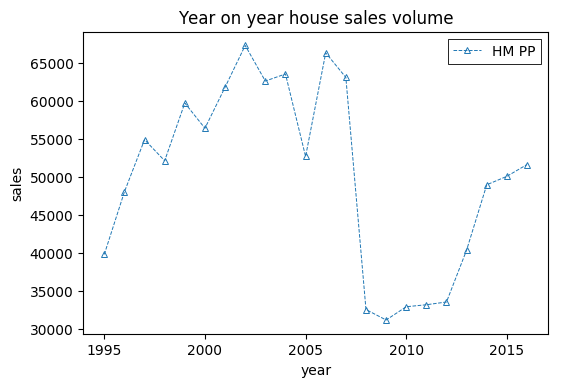

In [29]:
plt.rcParams['figure.dpi'] = 100
plt.plot(sales_by_year['year'], sales_by_year['count'], linestyle='--', marker='^', 
         markerfacecolor='none', markeredgewidth=0.7, label=r'HM PP')
plt.legend()
plt.title('Year on year house sales volume')
plt.xlabel('year')
plt.ylabel('sales')
plt.show()

---

## Mapping post codes into map tile regions
The code point open data set includes details of which county each UK postcode belongs. The data is freely available for [download](https://www.ordnancesurvey.co.uk/business-and-government/products/code-point-open.html) from Ordinance Survey.

In [30]:
CPO_DIR = os.getenv('DATA_CODEPO')

In [31]:
!tree $CPO_DIR | head -10

/home/csk13/src/uk-data-mapping/codepo_gb
├── Data
│   └── CSV
│       ├── ab.csv
│       ├── al.csv
│       ├── ba.csv
│       ├── bb.csv
│       ├── b.csv
│       ├── bd.csv
│       ├── bh.csv


The postcode data is split into many `.csv` files, each one named based on the [postcode area code](https://en.wikipedia.org/wiki/List_of_postcode_areas_in_the_United_Kingdom) - the first one or two letters of the post code.

A file specifying the column headers is provided. Let's take a look.

In [32]:
!head $CPO_DIR/Doc/Code-Point_Open_Column_Headers.csv

PC,PQ,EA,NO,CY,RH,LH,CC,DC,WC
Postcode,Positional_quality_indicator,Eastings,Northings,Country_code,NHS_regional_HA_code,NHS_HA_code,Admin_county_code,Admin_district_code,Admin_ward_code


Let's take a look at a few entries from one of the .csv files

In [33]:
!head -3 $CPO_DIR/Data/CSV/ab.csv

"AB101AB",10,394235,806529,"S92000003","","S08000020","","S12000033","S13002842"
"AB101AF",10,394181,806429,"S92000003","","S08000020","","S12000033","S13002842"
"AB101AG",10,394230,806469,"S92000003","","S08000020","","S12000033","S13002842"


Building mapping between postcode and district code.

In [34]:
%%time
postarea_code_fnames = [str(path) for path in (Path(CPO_DIR) / 'Data/CSV').glob('*.csv')]

postcode_to_district_map = {
    x[1]: x[2] 
    for fname in postarea_code_fnames 
    for x in pd.read_csv(fname, usecols=(0,8,), header=None).itertuples()
}

CPU times: user 2.29 s, sys: 166 ms, total: 2.45 s
Wall time: 2.6 s


In [35]:
len(postcode_to_district_map)

1698194

Finally, the mapping tables can be combined to obtain the index of the shapefile record corresponding to the district to which a given postcode belongs

In [36]:
def shp_record_for_postcode(pc):
    try:
        return district_to_shp_record_map[postcode_to_district_map[pc]]
    except KeyError:
        return

---

## Mean house price throughout UK in 2016

The postcodes in the Code Point Open dataset and the Price Paid dataset are in different formats. It's necessary to remove spaces from the postcodes in the Price Paid dataset.

In [37]:
pp = pp.withColumn('postcode', udf(lambda x: x.replace(' ', '').upper(), StringType())(pp['postcode']))

In order to aggregate data at the district level we first need to assign each row to a district using the mapping defined by `postcode_to_district_map`.

In [38]:
pp = pp.withColumn(
    'district_id',
    udf(lambda x: postcode_to_district_map.get(x), StringType())(pp['postcode'])
).dropna(subset=['district_id'])

In [39]:
%%time
pp_2016 = pp.filter(year(pp['date_of_transfer_datetime']) == 2016)
pp_2016.count()

CPU times: user 10.7 ms, sys: 1.1 ms, total: 11.8 ms
Wall time: 28.4 s


In [40]:
pp_2016_df = pp_2016.toPandas()

In [41]:
pp_2016_df.head()

,id,price,date_of_transfer,postcode,property_type,is_new,duration,PAON,SAON,street,locality,town_city,district,county,ppd_category_type,record_status,date_of_transfer_datetime,district_id
0,{31FB4C17-ABF8-57B9-E050-A8C063053436},495000,2016-03-24 00:00,UB100HP,S,N,F,99,None,MISBOURNE ROAD,None,UXBRIDGE,HILLINGDON,GREATER LONDON,A,A,2016-03-24,E09000017
1,{31FB4C17-A9DD-57B9-E050-A8C063053436},236000,2016-03-01 00:00,TD151NW,S,N,F,26,None,MEADOW GRANGE,None,BERWICK-UPON-TWEED,NORTHUMBERLAND,NORTHUMBERLAND,A,A,2016-03-01,E06000057
2,{31FB4C17-A9EC-57B9-E050-A8C063053436},191995,2016-04-15 00:00,NE250FP,D,Y,L,4,None,CHIRDON WAY,SEATON DELAVAL,WHITLEY BAY,NORTHUMBERLAND,NORTHUMBERLAND,A,A,2016-04-15,E06000057
3,{31FB4C17-AA10-57B9-E050-A8C063053436},20000,2016-04-11 00:00,NE241SB,T,N,F,19,None,DALE STREET,CAMBOIS,BLYTH,NORTHUMBERLAND,NORTHUMBERLAND,A,A,2016-04-11,E06000057
4,{31FB4C17-AA36-57B9-E050-A8C063053436},73500,2016-04-01 00:00,NE646LD,S,N,F,25,None,PELAW AVENUE,None,NEWBIGGIN-BY-THE-SEA,NORTHUMBERLAND,NORTHUMBERLAND,A,A,2016-04-01,E06000057


In [42]:
pp_2016_df.count()

id                           24170
price                        24170
date_of_transfer             24170
postcode                     24170
property_type                24170
is_new                       24170
duration                     24170
PAON                         24170
SAON                          2965
street                       23606
locality                      9736
town_city                    24170
district                     24170
county                       24170
ppd_category_type            24170
record_status                24170
date_of_transfer_datetime    24170
district_id                  24170
dtype: int64

In [43]:
pp_2016_mean_prices = pp_2016_df.groupby('district_id').agg({'price':'mean'})

In [44]:
%%time

def shp_record_for_district(d_id):
    try:
        return district_to_shp_record_map[d_id]
    except KeyError:
        return
    
pp_2016_mean_prices['shp_record'] = pp_2016_mean_prices.apply(
    lambda x: shp_record_for_district(x.name), axis=1
).astype(np.int64)

CPU times: user 9.09 ms, sys: 162 µs, total: 9.25 ms
Wall time: 76.2 ms


In [45]:
%%time

def shp_record_for_district(d_id):
    try:
        return district_to_shp_record_map[d_id]
    except KeyError:
        return
    
pp_2016_mean_prices['shp_record'] = pd.Series(
    [shp_record_for_district(x) for x in pp_2016_mean_prices.index], 
    pp_2016_mean_prices.index
)

CPU times: user 610 µs, sys: 98 µs, total: 708 µs
Wall time: 625 µs


**Note**: There is a discrepency between the number of calculated district mean prices in the dataframe and the number of districts present in the shapefile.

In [46]:
pp_2016_mean_prices.info()

<class 'pandas.core.frame.DataFrame'>
Index: 278 entries, E06000001 to W06000024
Data columns (total 2 columns):
price         278 non-null float64
shp_record    278 non-null int64
dtypes: float64(1), int64(1)
memory usage: 6.5+ KB


In [47]:
sf_district.numRecords

380

#### Create a new shapefile with additional attribute
It's best to create a new shapefile with additional attributes rather than editing an existing shapefile in place. Details of [how to write shapefile data to file](https://github.com/GeospatialPython/pyshp#writing-shapefiles) can be found in the `pyshp` repo.

In [48]:
records = sf_district.records()

sf_writer = shp.Writer()
sf_writer.fields = list(sf_district.fields)
sf_writer.fields = list(sf_district.fields) + [["2016_MEAN_PRICE", "N", 12, 3]]
    
for rec in records:
    rec.append(0.)  # Ensures all shapes have a mean price value
    
for idx, row in pp_2016_mean_prices.iterrows():
    records[int(row['shp_record'])][-1] = row['price']

sf_writer.records = records
sf_writer._shapes.extend(sf_district.shapes())

sf_writer.save("uk-2016-mean-price") 

---
### Plotting map

In [49]:
sf = shp.Reader("uk-2016-mean-price")

Dictionary to isolate London districts.

In [51]:
LONDON_POSTCODES_CSV = os.getenv('DATA_LONDON_POSTCODES')
london_districts_df = pd.read_csv(LONDON_POSTCODES_CSV, usecols=(10,))
london_districts = {x: None for x in london_districts_df['District Code'].unique()}
sf_london_idx = np.array([i for i in range(sf.numRecords) if sf.record(i)[8] in london_districts])
assert len(sf_london_idx) == len(london_districts)

The `pyproj` package is useful for converting between geographic projections. Projection formats are specified by [ESPG codes](http://spatialreference.org/).

In [52]:
wgs84=pyproj.Proj("+init=EPSG:4326")     # LatLon with WGS84 datum used by GPS units and Google Earth
osgb36 = pyproj.Proj("+init=EPSG:27700") # UK Ordnance Survey, 1936 datum

London_LonLat = (-0.1278, 51.5074)        # Lon-Lat geospatial coords for London
London_osgb36 = osgb36(*London_LonLat)   # Lon-Lat OS National Grid coords for London

OSGB36 Coords of the top10 UK cities by population. List of UK cities by population is available [here](http://www.citymayors.com/gratis/uk_topcities.html). WGS84 Lat-Long coordinates were obtained from Google Maps. It is important to note that **positive latitude** specifies and angle **North** of the equator and **positive longitude** specifies an angle **East** of the prime meridian.

In [53]:
uk_cities_top10_wgs84 = {
    'London': [(51.5074, -0.1278), (50.523194, 0.355571)],
    'Birmingham': [(52.4862, -1.8904), (50.253231, -1.88417)],
    'Leeds': [(53.8008, -1.5491), (54.775133, -0.875307)],
    'Glasgow': [(55.8642, -4.2518), (54.846665, -7.336002)],
    'Sheffield': [(53.3811, -1.4701), (53.150688, 0.603948)],
    'Bradford': [(53.7960, -1.7594), (55.177306, -1.134410)],
    'Liverpool': [(53.4084, -2.9916), (53.597492, -5.146998)],
    'Edinburgh': [(55.9533, -3.1883), (56.308727, -2.116987)],
    'Manchester': [(53.4808, -2.2426), (54.004974, -5.715788)],
    'Bristol': [(51.4545, -2.5879), (50.149561, -3.247066)],
}

uk_cities_top10_osgb36 = {
    k: osgb36(lon, lat) 
    for k, ((lat, lon), _) in uk_cities_top10_wgs84.items()
}
uk_cities_top10_labels_osgb36 = {
    k: osgb36(lon, lat) 
    for k, (_, (lat, lon)) in uk_cities_top10_wgs84.items()
}

In [54]:
uk_cities_top10_osgb36

{'London': (529915.8259598681, 180433.9938870187),
 'Birmingham': (407441.59663470316, 287633.45594173216),
 'Leeds': (429694.25737852394, 433951.22248979274),
 'Glasgow': (259095.16632049525, 665735.5205742274),
 'Sheffield': (435244.32054710225, 387299.03216908325),
 'Bradford': (415846.6846645916, 433349.79639267735),
 'Liverpool': (334090.2975010383, 390663.0040515137),
 'Edinburgh': (325808.153663839, 673996.2847710882),
 'Manchester': (383902.0295161803, 398286.245722139),
 'Bristol': (359155.7086262001, 173053.65671517007)}

Plotting shapefile with districts coloured by mean price

/home/csk13/src/uk-data-mapping/venv/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log10
  # This is added back by InteractiveShellApp.init_path()


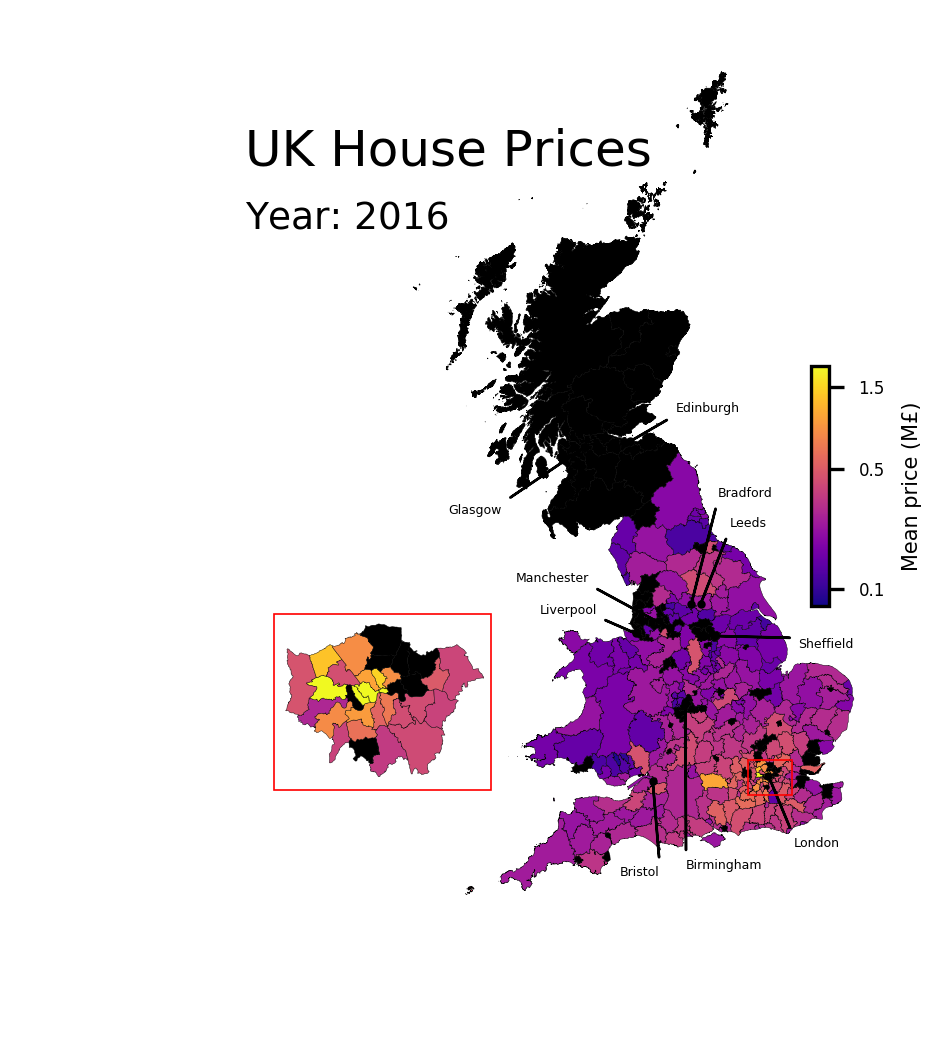

In [55]:
plt.rcParams['figure.dpi'] = 300

price2016_idx = 15
mean_price2016 = np.array([rec[price2016_idx] for rec in sf.records()])

fig, ax = plt.subplots(1)
ax.set_aspect('equal')  # Need equal aspect ratio to prevent skewed geometry
plt.axis('off')

# Set plot colormap and colours
log_mean_price2016 = np.where(mean_price2016 > 0., np.log10(mean_price2016), 0.)
#vmin, vmax = log_mean_price2016[log_mean_price2016 > 0].min(), log_mean_price2016.max()
vmin, vmax = np.log10(8.0e4), np.log10(2.0e6)
norm = colors.Normalize(vmin=vmin, vmax=vmax)
cmap = plt.get_cmap('plasma')

# Create list of polygon patches for all districts
patches = []
colours = []
for i, shape in enumerate(sf.shapes()):
    for points in np.split(np.array(shape.points), shape.parts)[1:]:
        polygon = Polygon(points, closed=True)
        patches.append(polygon)
        colour = cmap(norm(log_mean_price2016[i])) if log_mean_price2016[i] > 0. \
            else np.array([0., 0., 0., 1.])
        colours.append(colour)

collection = PatchCollection(patches)
collection.set_facecolor(colours)
collection.set_linewidths(0.1)
ax.add_collection(collection)

# Create list of polygon patches for London districts
patches_ldn = []
colours_ldn = []
scale = 5.
trans = np.array([-2.7e6, -6.0e5])
for idx in sf_london_idx:
    for points in np.split(np.array(sf.shape(idx).points), sf.shape(idx).parts)[1:]:
        points *= scale  # Increase size of London districts
        points += trans  # Shift London districts
        polygon = Polygon(points, closed=True)
        patches_ldn.append(polygon)
        colour = cmap(norm(log_mean_price2016[idx])) if log_mean_price2016[idx] > 0. \
            else np.array([0., 0., 0., 1.])
        colours_ldn.append(colour)

collection_ldn = PatchCollection(patches_ldn)
collection_ldn.set_facecolor(colours_ldn)
collection_ldn.set_linewidths(0.1)
ax.add_collection(collection_ldn)

# Add boxes around London
pos_lg, w_lg, h_lg = np.array([-2.e5, 1.6e5]), 3.2e5, 2.6e5
pos_sm, w_sm, h_sm = (pos_lg - trans) / scale, w_lg / scale, h_lg / scale 
rect_lg = Rectangle(pos_lg, w_lg, h_lg, angle=0.0, fill=False, linewidth=0.4, color='r')
rect_sm = Rectangle(pos_sm, w_sm, h_sm, angle=0.0, fill=False, linewidth=0.4, color='r', zorder=10)
ax.add_patch(rect_lg)
ax.add_patch(rect_sm)

ax.autoscale_view()

# Create colorbar independent of plot elements 
cax = fig.add_axes([0.65, 0.4, 0.01, 0.2])
cbar = colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, ticks=np.log10([1.0e5, 5.0e5, 1.5e6]))
cbar.ax.set_yticklabels(['0.1', '0.5', '1.5'])
cbar.set_label(u'Mean price (M\u00a3)', fontsize=5)
cbar.ax.tick_params(labelsize=4)

# Add points indicating 10 biggest cities
for label, (x, y) in uk_cities_top10_osgb36.items():
    ax.scatter(x, y, label=label, c='black', s=2.)

for label, (xy, xytext) in uk_cities_top10_wgs84.items():
    ax.annotate(label, xy=osgb36(xy[1], xy[0]), xytext=osgb36(xytext[1], xytext[0]), xycoords='data',
                fontsize=3, horizontalalignment='left', verticalalignment='bottom', 
                arrowprops=dict(color='black', shrink=0., width=0.05, headwidth=0.05, headlength=0.05))
    
ax.text(0.0, 0.85, 'UK House Prices', transform=ax.transAxes, fontsize=12)
ax.text(0.0, 0.78, 'Year: %d' % 2016, transform=ax.transAxes, fontsize=9)

plt.show()

**TODO**
- Figure out why there are so many null values in the mean price data and fix.
- Show only mainland UK districts.
- ~~Resize colorbar and display labels in £.~~
- Decide optimal value range for colorbar. Extremes in data reduce colour variation so should be clipped.
- ~~Add inset showing London~~
- ~~Add labelled dots showing [UK top cities by population](http://www.citymayors.com/gratis/uk_topcities.html).~~
- Add title indicating year in each plot.
- Adjust house prices for inflation
- Show house prices relative to median income for 30-35 year olds adjusted for inflation
- Run for full dataset. Produce a single graph for each year using consistent colour normalisation.